In [527]:
import numpy as np
from fourier import compute_fourier_coeff
from signal_functions import truncated_sine_series
from fourier import compute_fourier_coeff
from kernels import complex_exponential_kernel, cosine_kernel, dirichlet_kernel_shifted
from inference_utils import  run_inference_frequency_localized, run_inference_error_frequency_localized
from plotting import  plot_true_vs_approximation, plot_error_with_std

import matplotlib.pyplot as plt

In [528]:
#TODO
# lambda has to be very small (and not only depend on N) to get a good approx
#why are the Fourier coefficients of the kernel also negative? the imaginary part seems small enough

In [529]:
#CHOOSE number of input functions
num_samples = 250

grid_size = 2**11 # grid points

t_left = 0
t_right = 1

time_span = t_right - t_left

time_array = np.linspace(t_left,t_right,grid_size)


In [530]:
#parameter for target signal
target_decay_rate = 1.1 # decay rate of the target signal   #2.51
noise = .01 # noise level

In [531]:
# Ground truth function and observation  noise         
# y_i = x_i * target + noise, where x_i is the input signal

sum_terms_target = 3  # index  of truncation of the fourier series
target = truncated_sine_series(
    input_points=time_array, decay_rate=target_decay_rate, num_terms=sum_terms_target
)

##fourier coefficients of w_true
target_fourier_coeff = compute_fourier_coeff(
    target, time_span
)  # normalized by the number of grid points


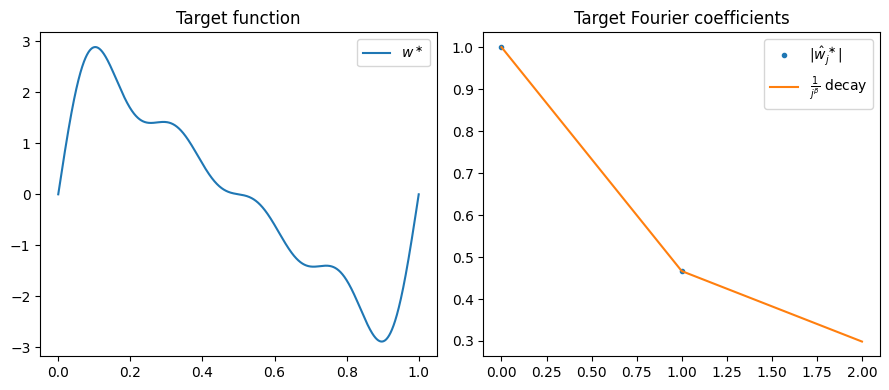

In [532]:
# Visualize the target function and its fourier coefficients decay

#plot the true function and its fourier coefficients in two subplots
fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(9, 4))
ax1.plot(time_array,target, label = r'$w^\ast$')
ax1.set_title('Target function')
ax1.legend()

plot_till = sum_terms_target

ax2.plot(np.abs(target_fourier_coeff)[1:plot_till], '.', label=r'$|\hat{w}^\ast_j|$')
# Create auxiliary vector for decay comparison
j_values = np.arange(1, target_fourier_coeff.size + 1, dtype=float)

ax2.plot(j_values[:plot_till]**(-target_decay_rate), label=r'$\frac{1}{j^\beta}$ decay')
ax2.set_title('Target Fourier coefficients')
ax2.legend()
plt.tight_layout()

In [533]:
# the kernel

# complex exponential kernel
kernel_decay_rate =   1.01 # decay rate of the  complex exponential kernel   #1.01
sum_terms_kernel = sum_terms_target
evaluated_kernel = complex_exponential_kernel(time_array, kernel_decay_rate, sum_terms_kernel)
kernel_coeff = compute_fourier_coeff(evaluated_kernel, time_span)
kernel_coeff_abs = np.abs(kernel_coeff)   #TODO why do you need to take abs?


# # dirichlet kernel
# order_dirichlet_ker = sum_terms_target
# evaluated_kernel = dirichlet_kernel_shifted(time_array, order_dirichlet_ker, L=1/2)
# kernel_decay_rate = 0

# kernel_coeff = compute_fourier_coeff(evaluated_kernel, time_span)
# kernel_coeff_abs = np.abs(kernel_coeff)   #TODO why do you need to take abs?
# kernel_coeff = np.ones(grid_size)


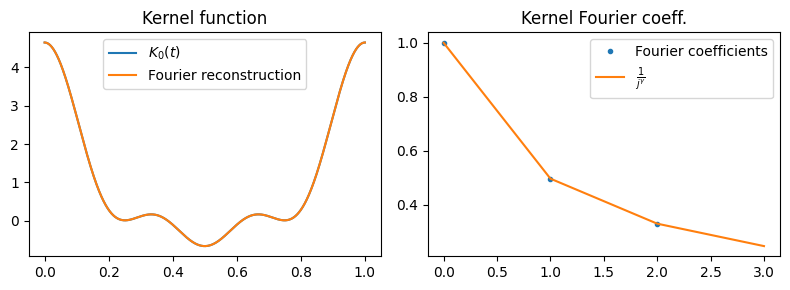

In [534]:
# visualize the kernel's fourier coefficients decay  (for the complex exponential kernel)

fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(8, 3))
ax1.plot(time_array, evaluated_kernel, label=r'$K_0(t)$')
ax1.set_title('Kernel function')
ax1.plot(time_array, np.fft.ifft(kernel_coeff*grid_size), label='Fourier reconstruction')
ax1.legend()

plot_till = sum_terms_kernel 
ax2.plot(kernel_coeff_abs[1:plot_till+1], '.', label='Fourier coefficients')
aux_vec=np.arange(1,kernel_coeff.size+1, dtype=float)
ax2.plot(aux_vec[:plot_till+1]**(-kernel_decay_rate), label=r'$\frac{1}{j^\gamma}$')
ax2.set_title('Kernel Fourier coeff.')
ax2.legend()
plt.tight_layout()


In [535]:
# freq-loc signals

freq_loc_inputs_decay =1.2   #.2  
freq_max = sum_terms_target 

alpha_sup = (2*target_decay_rate -1 - kernel_decay_rate) / 2*(kernel_decay_rate + freq_loc_inputs_decay)

print("alpha_sup" , alpha_sup)
alpha = .3*alpha_sup

b = kernel_decay_rate + freq_loc_inputs_decay

alpha_sup 0.2099500000000002


In [536]:
print(b)

2.21


In [537]:
print(num_samples ** (-1 / (2 * alpha + 1 + 1/b)))

0.030257600389991392


__Source conditions__:

$$ 
\sum_{l \in \mathbb{Z}} \frac{{|\hat{w}^\ast_l|^2 } }{\hat{k}_l( \hat{k}_l \mathbb{E}[|\hat{X}_l|^2])^{2\alpha}}  < + \infty
$$

with  $ \gamma_l :=  \hat{k}_l\, \mathbb{E}[|\hat{X}_l|^2] $ eigenvalues of covariance operator.

__Frequency localized signals__: 
 $$X(t) = e^{2 \pi i L t} =  \cos(2 \pi L t) + i \sin(2 \pi L t) $$
where $L$ is a $ \rho $-distributed random variable on $\mathbb{Z}$.

Eigenvalues of covariance operator: $\gamma_l = \hat{k}_l \rho_l$ we choose $ \rho_l = \frac{1}{l^\eta} $


Source conditions: 
$$\sum_l \frac{l^{-2\beta}}{l^{-2\alpha(\gamma + \eta)} l^{-\gamma}} < \infty 
\quad \rightarrow \quad \alpha < \frac{2 \beta -1 -\gamma}{2 (\gamma + \eta)}. $$

If we choose the Dirichlet kernel, we have $\hat{k}_l = 1  \ \forall l$ so it becomes:

$$\sum_l \frac{l^{-2\beta}}{l^{-2\alpha\eta} } < \infty 
\quad \rightarrow \quad \alpha < \frac{2 \beta -1}{2  \eta}. $$


In this case, if $\eta \alpha >> \beta$ bad for convergence

if $\eta \alpha << \beta$ good for convergence

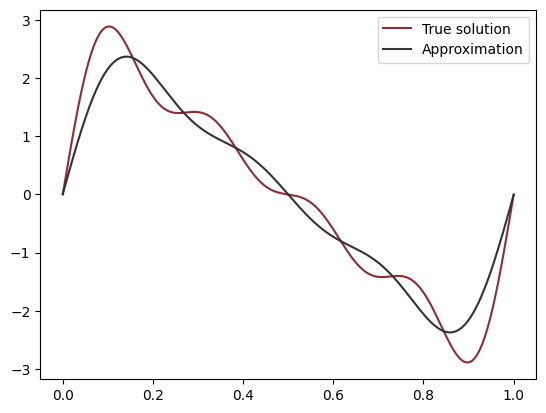

In [538]:
# run inference for time-localized signals
pred_fourier_coeff, pred_time = run_inference_frequency_localized(
    num_samples=num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_fourier_coeff=target_fourier_coeff,
    noise=noise,
    alpha=alpha,
    b = b,
    freq_loc_inputs_decay=freq_loc_inputs_decay,
    freq_max=freq_max,
)
plot_true_vs_approximation(time_array, target, pred_time)

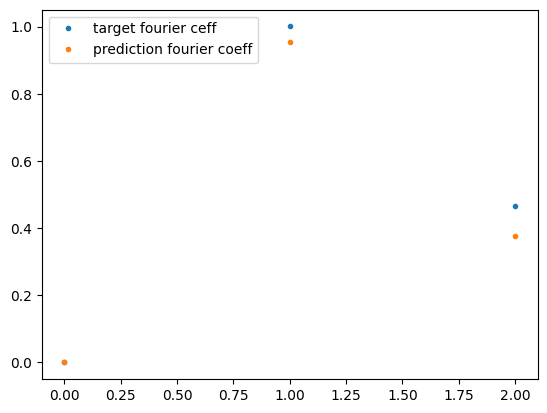

In [539]:
plt.plot(np.abs(target_fourier_coeff[:sum_terms_target]), '.', label='target fourier ceff')
plt.plot(np.abs(pred_fourier_coeff[:sum_terms_target]), '.', label='prediction fourier coeff')
plt.legend()

In [540]:
# error_squared_sampmean_freq_loc, error_squared_sampstd_freq_loc, error_logmean_freq_loc, error_logstd_freq_loc = run_inference_error_frequency_localized(
#     num_samples=num_samples,
#     num_experiments=5,
#     time_array=time_array,
#     time_span=time_span,
#     kernel_coeff= kernel_coeff,
#     target_fourier_coeff=target_fourier_coeff,
#     noise=noise,
#     alpha=alpha,
#     b=b,
#     series_truncation=sum_terms_target,
#     freq_loc_inputs_decay=freq_loc_inputs_decay,
#     freq_loc_max=freq_max
# )
# plot_error_with_std(num_samples, error_sampmean_freq_loc, error_squared_sampstd_freq_loc)

In [541]:
# plt.plot(time_array, np.fft.ifft(pred_fourier_coeff) * (time_array.size / time_span), label='Fourier reconstruction')
# plt.plot(time_array, np.fft.ifft(pred_fft) * (time_array.size / time_span), label='Fourier reconstruction')